In [10]:
import sys
import numpy as np
import matplotlib.pyplot as plt

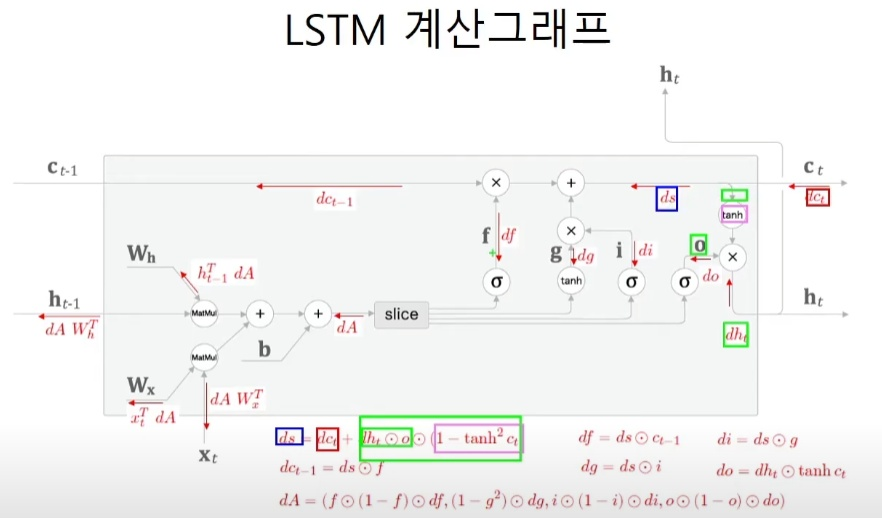

In [11]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def softmax(x):
  if x.ndim == 2:
      x = x - x.max(axis=1, keepdims=True)
      x = np.exp(x)
      x /= x.sum(axis=1, keepdims=True)
  elif x.ndim == 1:
      x = x - np.max(x)
      x = np.exp(x) / np.sum(np.exp(x))

  return x

In [12]:
class LSTM:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape

    A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b

    # slice
    f = A[:, :H]
    g = A[:, H:2*H]
    i = A[:, 2*H,3*H]
    o = A[:, 3*H,4*H]

    f = sigmoid(f) # forget gateway
    g = np.tanh(g) # 새로 기억될 input 정보
    i = sigmoid(i) # input gateway
    o = sigmoid(o) # output gateway

    '''
    cell update 과정
    forget gateway에서 주는 가중치와 이전 c를 아다마르 곱셈하여 중요하지 않은 것은 잊어주고
    input gateway에서 주는 가중치와 새로운 입력 g를 아다마르 곱셈하여 새로운 정보를 추가해준다.
    '''
    c_next = f * c_prev + g * i
    h_next = o * np.tanh(c_next) # output gateway에서 주는 가중치와 아다마르 곱셈으로 출력을 조절

    self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next

  def backward(self, dh_next):
    '''
    위의 이미지를 참고하자...
    순전파일 때 분기했을 경우 -> 역전파에서는 각 기울기가 합산되어 전해짐
    '''

    Wx, Wh, b = self.params
    x, h_prev, c_prev, i, f, g, o, c_next = self.cache

    ds = dc_next + (dh_next * o) * (1 - np.tanh(c_next)**2) # tanh(c_next) 미분

    di = ds * g
    df = ds * c_prev
    do = dh_next * np.tanh(c_next)
    dg = ds * i

    di *= i * (1-i)
    df *= f * (1-f)
    do *= o * (1-o)
    dg *= (1 - g ** 2)

    dA = np.hstack((df, dg, di, do))

    dWh = np.dot(h_prev.T, dA)
    dWx = np.dot(x.T, dA)
    db = dA.sum(axis=0)

    dx = np.dot(dA, Wx.T)
    dh_prev = np.dot(dA, Wh.T)

    return dx, dh_prev, dc_prev

In [13]:
class TimeLSTM:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_ilke(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None

    self.h, self.dh, self.c = None, None, None
    self.stateful = stateful

  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape  # N:미니배치 크기, T:시계열 데이터의 분량, D:입력벡터의 차원 수
    H = Wh.shape[0]     # Wh 형상 : (H, 4H)

    self.layers = []
    hs = np.empty((N, T, D), dtype='f')

    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype='f')
    if not self.stateful or self.c is None:
      self.c = np.zeros((N, H), dtype='f')

    for t in range(T):
      layer = LSTM(*self.params)
      self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
      hs[:, t, :] = self.h

      self.layers.append(layer)

    return hs

  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape     # N:미니배치 크기, T:시계열 데이터 분량, H:은닉 벡터의 차원 수
    D = Wx.shape[0]         # D:입력벡터의 차원 수

    dxs = np.empty((N, T, D), dtype='f')  # 역전파 입력
    dh, dc = 0, 0                         # 역전파를 거치며 합산된 기울기
    grads = [0, 0, 0]

    for t in reversed(range(T)): # 역순서로 순회
      layer = self.layers[t]
      dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
      dxs[:, t, :] = dx          # 각 시각 t에서 얻은 x 기울기를 저장

      # t를 순회할 때마다 역전파로 얻은 가중치를 위 로컬변수로 초기화 한 grads에 합산
      for i, grad in enumerate(layer.grads):
        grads[i] += grad

    # 합산된 가중치 기울기의 최종 결과를 멤버변수 self.grads에 덮어씀
    for i, grad in enumerate(grads):
      self.grads[i][...] = grad

    self.dh = dh

    return dxs

  def set_state(self, h, c=None):
    self.h, self.c = h, c

  def reset_state(self):
    self.h, self.c = None, None